# Gift Recommendation Engine: Experimentation

## Import Libraries and Dataset

In [2]:
import numpy as np
import pandas as pd
import json
import gzip
import warnings
from data_compile import *
warnings.filterwarnings('ignore')

In [3]:
import nltk
import string
import re

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [105]:
data = pd.read_csv('datasets/amazon-data-compiled.csv')

## Data Preprocessing and Exploratory Data Analysis

We first move missing rows and certain product categories within the dataset.

In [106]:
drop_categories = ['<img src="https://images-na.ssl-images-amazon.com/images/G/01/digital/music/logos/amzn_music_logo_subnav._CB471835632_.png" class="nav-categ-image" alt="Digital Music"/>',
                  '<img src="https://m.media-amazon.com/images/G/01/digital/music/logos/amzn_music_logo_subnav._CB471835632_.png" class="nav-categ-image" alt="Digital Music"/>',
                  '<img src="https://images-na.ssl-images-amazon.com/images/G/01/nav2/images/gui/amazon-fashion-store-new._CB520838675_.png" class="nav-categ-image" alt="AMAZON FASHION"/>',
                  'Industrial & Scientific']

data = data[~data.category.isin(drop_categories)]
data.dropna(inplace=True)
data.drop('Unnamed: 0', axis=1, inplace=True)

<b> How many categories are present in the dataset and how many reviews does each dataset have? </b>

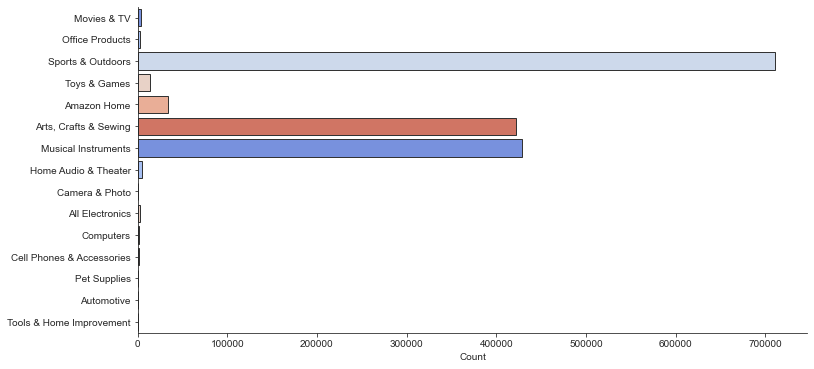

In [107]:
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(12,6))

sns.countplot(y = data['category'], palette=sns.color_palette('coolwarm'), edgecolor='.2')
ax.set(xlabel='Count', ylabel='')
sns.despine()
plt.show()

Data appears to be heavily skewed. The categories imported from the Amazon dataset actually contains only 4 categories: CDs, Arts and Crafts, and Musical Instruments, and Sports and Outdoors. It appears that some of the categories are split into further categories as their main category. We must fix this.

Let's explore the detailed category column and replace the under-classed groups with the detailed category. 

In [108]:
cat_size = data.groupby('category').size().reset_index().sort_values(0, ascending=False)
under_cat = cat_size[3:]['category'].to_list()
secondary_cat = data['detailed_cat'].apply(lambda x: x.split(',')[0])
data['secondary_cat'] = secondary_cat
under_df = data[data.category.isin(under_cat)]
under_df['category'] = under_df['secondary_cat']
over_df = data[~data.category.isin(under_cat)]
data = pd.concat([over_df, under_df]).drop('secondary_cat', axis=1)

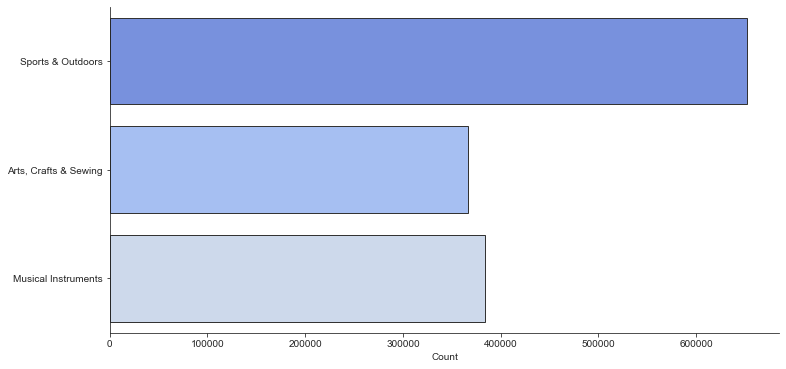

In [120]:
fig, ax = plt.subplots(figsize=(12,6))

sns.countplot(y = data['category'], palette=sns.color_palette('coolwarm'), edgecolor='.2')
ax.set(xlabel='Count', ylabel='')
sns.despine()
plt.show()

CDs and Vinyls are still heavily underrepresented. As I am doing this to experiment on this approach, I will just drop this category, so we are constructing a classifier with 3 distinct classes.

In [110]:
data = data[~data.category.isin(['CDs & Vinyl'])]

In [111]:
data.head()

,product_id,product_name,product_description,category,detailed_cat,feature,price,also_buy,also_view,imageURLHighRes,reviewer_id,verified,star_rating,upvotes,review_headline,review_body,num_reviews,avg_rating
147228,7245456313,Black Mountain Products Resistance Band Set wi...,Black Mountain Products (B.M.P.) resistance ba...,Sports & Outdoors,"Sports & Outdoors, Sports & Fitness, Exercise ...","Bands included: Yellow (2-4 lbs.), blue (4-6 l...",17.32,"1612431712, B01AVDVHTI, B002YQUP7Q, B0136PR5TO...",0,https://images-na.ssl-images-amazon.com/images...,A2Q0LT44D9YNJ5,True,5.0,23,Excellent Value for the money!,"I have recently started the P90x system, and r...",6130,4.614192
147229,7245456313,Black Mountain Products Resistance Band Set wi...,Black Mountain Products (B.M.P.) resistance ba...,Sports & Outdoors,"Sports & Outdoors, Sports & Fitness, Exercise ...","Bands included: Yellow (2-4 lbs.), blue (4-6 l...",17.32,"1612431712, B01AVDVHTI, B002YQUP7Q, B0136PR5TO...",0,https://images-na.ssl-images-amazon.com/images...,AQPY2R9DMJY0L,True,5.0,0,Great product.,These bands are great. So many possible exerci...,6130,4.614192
147230,7245456313,Black Mountain Products Resistance Band Set wi...,Black Mountain Products (B.M.P.) resistance ba...,Sports & Outdoors,"Sports & Outdoors, Sports & Fitness, Exercise ...","Bands included: Yellow (2-4 lbs.), blue (4-6 l...",17.32,"1612431712, B01AVDVHTI, B002YQUP7Q, B0136PR5TO...",0,https://images-na.ssl-images-amazon.com/images...,A13VDTDCYOPYIT,True,5.0,0,Five Stars,great,6130,4.614192
147231,7245456313,Black Mountain Products Resistance Band Set wi...,Black Mountain Products (B.M.P.) resistance ba...,Sports & Outdoors,"Sports & Outdoors, Sports & Fitness, Exercise ...","Bands included: Yellow (2-4 lbs.), blue (4-6 l...",17.32,"1612431712, B01AVDVHTI, B002YQUP7Q, B0136PR5TO...",0,https://images-na.ssl-images-amazon.com/images...,ASZX3X4F4PVH6,True,5.0,0,Trainer using these for 1yr+,I have used these bands with clients for over ...,6130,4.614192
147232,7245456313,Black Mountain Products Resistance Band Set wi...,Black Mountain Products (B.M.P.) resistance ba...,Sports & Outdoors,"Sports & Outdoors, Sports & Fitness, Exercise ...","Bands included: Yellow (2-4 lbs.), blue (4-6 l...",17.32,"1612431712, B01AVDVHTI, B002YQUP7Q, B0136PR5TO...",0,https://images-na.ssl-images-amazon.com/images...,A3LTT7Y9511XI5,True,5.0,0,The Best Resistance Bands!,These bands are perfect. You can do so many e...,6130,4.614192


Next, I filtered all the positive ratings and I extracted only reviews that contained greater than 50 words. I later saw that there was still a lot of data and since I want to create a quick and rough model for experimentation, I decided to take the top 1000 reviews based on length from each category and compiled that into a dataframe.

In [112]:
data = data[data.star_rating >= 4.0]

In [113]:
data['split_text'] = data.review_body.apply(lambda x: x.split())

In [114]:
data['len_text'] = data.split_text.apply(lambda x: len(x))

In [121]:
test = data[data.len_text >= 50]

In [122]:
arts = test[test.category == 'Arts, Crafts & Sewing'].sort_values('len_text', ascending=False)[1:1001]
sports = test[test.category == 'Sports & Outdoors'].sort_values('len_text', ascending=False)[:1000]
music = test[test.category == 'Musical Instruments'].sort_values('len_text', ascending=False)[:1000]

In [123]:
test = pd.concat([arts, sports, music])

In [119]:
data.category.unique()

array(['Sports & Outdoors', 'Arts, Crafts & Sewing',
       'Musical Instruments'], dtype=object)

In [124]:
test.category.unique()

array(['Arts, Crafts & Sewing', 'Sports & Outdoors',
       'Musical Instruments'], dtype=object)

<b> How many positive reviews are there in each category? </b> 

## Data Transformation

The target variable for this model is the category, which will have to be label encoded. I had to clean up my feature column, which was the review body, by removing stopwords and punctuations, performing lemmatization, and converting each character into lowercase. I then split the dataset into training and testing dataset and created a TF-IDF vectorizer that was fit on the training features to convert text data into numerical representation.

In [125]:
relevant_data = test[['category', 'review_body']]

In [126]:
relevant_data['category'].unique()

array(['Arts, Crafts & Sewing', 'Sports & Outdoors',
       'Musical Instruments'], dtype=object)

In [129]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
relevant_data['target'] = le.fit_transform(relevant_data['category'])

In [204]:
punctuations = string.punctuation

def remove_punc(text):
    return ''.join([word for word in text if word not in punctuations])

stopwords = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    return [word for word in text.split() if word not in stopwords]

def convert_lowercase(text):
    return ''.join([word.lower() for word in text])

def preprocess(text):
    text = re.sub(r'\b\w{1,2}\b', '', text)
    text = remove_punc(text)
    text = convert_lowercase(text)
    text = remove_stopwords(text)
    return text

In [131]:
import spacy
nlp = spacy.load('en_core_web_sm')

def spacy_lemmatize(text):
    if type(text) == list:
        doc = nlp(u"{}".format(' '.join(text)))
    else:
        doc = nlp(u"{}".format(text))
    lemmatized = list()
    for token in doc:
        lemmatized.append(token.lemma_)
    
    return lemmatized

In [132]:
relevant_data['review_body'] = relevant_data['review_body'].map(preprocess).map(spacy_lemmatize).apply(lambda x: ' '.join([word for word in x if word not in punctuations])).map(str)

In [133]:
X = relevant_data['review_body']
y = relevant_data['target']

In [134]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8, stratify=y)

In [135]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [136]:
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train)

## Modelling

I tried to make a quick classification model using the multinomial naive bayes classifier, fit on my training dataset.

In [137]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

I tested the model on my testing dataset and it achieved a very good accuracy score. Then, I tried taking some user tweets and see what categories the model predicts. In this example, I copied a tweet from a user I follow talking about the 49ers, and the model was able to classify on sports. I tried on a variety of examples as well (tweets that can be categorized into the following categories) 

In [138]:
# Test
X_test = tfidf.transform(X_test)

In [139]:
nb.score(X_test, y_test)

0.9716666666666667

In [140]:
import pickle
file = open('naive_bayes_trial.pkl', 'wb')
pickle.dump(nb, file)

In [84]:
import pickle
file = open('naive_bayes_trial.pkl', 'rb')
nb = pickle.load(file)

In [213]:
user_test = "I went to the Grammys and saw Rihanna! "

In [214]:
user_text = preprocess(user_test)

In [215]:
user_text = spacy_lemmatize(user_test)

In [216]:
user_text = ' '.join(user_text)

In [217]:
user_text = tfidf.transform([user_text])

In [218]:
nb.predict(user_text)

array([2])

In [219]:
relevant_data[relevant_data.target == 2]

,category,review_body,target
649882,Sports & Outdoors,fuzzy wuzzy summary highly recommend warm fuzz...,2
650224,Sports & Outdoors,fuzzy wuzzy summary highly recommend warm fuzz...,2
513640,Sports & Outdoors,absolutely blow away quality hornady lock load...,2
432564,Sports & Outdoors,review update 2012 update follow initial revie...,2
819939,Sports & Outdoors,far love intex motor mount kit composite plast...,2
...,...,...,...
919884,Sports & Outdoors,buy ice chest take raft trip put raft river ta...,2
818748,Sports & Outdoors,purchase month ago means easily get moor sailb...,2
353266,Sports & Outdoors,wife recently get back camping colorado wilder...,2
800643,Sports & Outdoors,scoff commercial great idea scoff chuck norris...,2
